# Segmentation and Classification of Mammographic Images

In [1]:
# Imports
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os.path
from fastai.vision.all import *
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

# Benchmark CPU x GPU

In [18]:
# Create default model to test
def conv_model(device, filters, kz):
    with tf.device(device):
        model = Sequential()
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        model.summary()

        return model

# Run model and compute time
def run(model, x_train, y_train, epochs=128, batch_size=32):
    start = time()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
    end = time()

    return end - start

# Load dataset mnist
(x_train, y_train), (_, _) = mnist.load_data()

# Preprocessing data
x_train = x_train / 255.0 # Normalize
x_train = x_train.reshape(-1, 28, 28, 1) # Add the channel axis
y_train = to_categorical(y_train, num_classes=10) # Convert to one-hot encoding

# Define CPU and GPU models
cpu_model = conv_model('CPU', 64, 3)
gpu_model = conv_model('DML', 64, 3)

# Default hiperparams
epochs = 8
bz = 64

# Run models
conv_cpu_time = run(cpu_model, x_train, y_train, epochs=epochs, batch_size=bz)
conv_gpu_time = run(gpu_model, x_train, y_train, epochs=epochs, batch_size=bz)

# Computation time
print("Time to train with CPU:", conv_cpu_time)
print("Time to train with GPU:", conv_gpu_time)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)              

# Auxiliary Functions

In [4]:
# Get all data from a directory and return as a dataframe
def get_dataset(folder_path):
    folder = Path(folder_path)

    filepaths = list(folder.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    return pd.concat([filepaths, labels], axis=1)

# Check if is multiple of 4
def is_multiple_of_4(number):
    number = number.split("(")[-1].split(")")[0]
    number = number.strip()
    return int(number) % 4 == 0

# Split dataframe into train and validation
def split_train_and_validation(dataset):
    images_train = dataset[~dataset['Filepath'].apply(is_multiple_of_4)]
    images_validation = dataset[dataset['Filepath'].apply(is_multiple_of_4)]

    print("Training set:")
    print("Quantity of samples:", len(images_train))
    print("Quantity of classes:", len(images_train['Label'].unique()))
    print()

    print("Validation set:")
    print("Quantity of samples:", len(images_validation))
    print("Quantity of classes:", len(images_validation['Label'].unique()))
    
    return images_train, images_validation

# Map labels based on initial
def map_label(label):
    if label.startswith('D'):
        return 'I'
    elif label.startswith('E'):
        return 'II'
    elif label.startswith('F'):
        return 'III'
    elif label.startswith('G'):
        return 'IV'
    else:
        return label
    
# Crop the image
def crop_image(image):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Define the coordinates of the region of interest (ROI)
    x = 15
    y = 15
    crop_width = width - 30
    crop_height = height - 30
    
    return image[y:y+crop_height, x:x+crop_width]

# Find the optimal gamma for the image
def find_optimal_gamma(image):
    # Calculate average of pixels
    mean = np.mean(image)

    # Return the optimal gamma number for this image
    return np.log(mean) / np.log(512)

# Identify the largest object in the image
def biggest_object(image):
    # Perform labeling of connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

    # Find the index of the largest object (excluding the background)
    largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a mask only for the largest object
    return np.uint8(labels == largest_label) * 255

# Segment a image
def segment_image(image):
    # Crop image, removing 15 pixels from the edges
    cropped = crop_image(image)
    
    # Set the ideal gamma
    gamma = find_optimal_gamma(image)
    
    # Apply gamma and Otsu transformation if necessary, otherwise apply only Threhold Binary
    if gamma >= 0.6:
        gamma_corrected = np.power(cropped / 255.0, gamma)
        image_filtered = np.uint8(gamma_corrected * 255)
        _, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        image_filtered = cropped
        _, result = cv2.threshold(image_filtered, 1, maxval=255, type=cv2.THRESH_BINARY)
        
    # Largest object in the image (breast)
    image_biggest = biggest_object(result)
    
    # Match the mask of the largest object with the original cropped image
    return cv2.bitwise_and(cropped, cropped, mask=image_biggest)

# Function to display images
def display_variations(filepaths):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # Create a figure with one row and four columns

    titles = ["Original Segmented", "Flipped", "Equalized", "Flipped Equalized"]

    for i, filepath in enumerate(filepaths):
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(titles[i])  # Set the title based on the titles list
        
    plt.tight_layout()
    plt.show()

# Load Images into Dataframe

In [5]:
# Read images from directory
folder_path = './images/'
dataset = get_dataset(folder_path)
dataset

,Filepath,Label
0,images\DleftCC\d_left_cc (1).png,DleftCC
1,images\DleftCC\d_left_cc (10).png,DleftCC
2,images\DleftCC\d_left_cc (100).png,DleftCC
3,images\DleftCC\d_left_cc (101).png,DleftCC
4,images\DleftCC\d_left_cc (102).png,DleftCC
...,...,...
5019,images\GrightMLO\g_right_mlo (95).png,GrightMLO
5020,images\GrightMLO\g_right_mlo (96).png,GrightMLO
5021,images\GrightMLO\g_right_mlo (97).png,GrightMLO
5022,images\GrightMLO\g_right_mlo (98).png,GrightMLO


# Change Label

In [6]:
# Apply the function to the values ​​of "Label"
dataset['Label'] = dataset['Label'].apply(map_label)
dataset

,Filepath,Label
0,images\DleftCC\d_left_cc (1).png,I
1,images\DleftCC\d_left_cc (10).png,I
2,images\DleftCC\d_left_cc (100).png,I
3,images\DleftCC\d_left_cc (101).png,I
4,images\DleftCC\d_left_cc (102).png,I
...,...,...
5019,images\GrightMLO\g_right_mlo (95).png,IV
5020,images\GrightMLO\g_right_mlo (96).png,IV
5021,images\GrightMLO\g_right_mlo (97).png,IV
5022,images\GrightMLO\g_right_mlo (98).png,IV


In [7]:
# Disinct labels and count
dataset['Label'].value_counts()

I      1256
II     1256
III    1256
IV     1256
Name: Label, dtype: int64

# Split Train and Validation

In [2]:
def get_train():
    dir = Path('../images/train')

    filepaths = list(dir.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    return pd.concat([filepaths , labels] , axis=1)

def get_test():
    dir = Path('../images/test')

    filepaths = list(dir.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    return pd.concat([filepaths , labels] , axis=1)

In [3]:
train = get_train()
test = get_test()

In [4]:
# Split dataset segmented
train

,Filepath,Label
0,..\images\train\F\F1.png,F
1,..\images\train\F\F10.png,F
2,..\images\train\F\F100.png,F
3,..\images\train\F\F101.png,F
4,..\images\train\F\F102.png,F
...,...,...
99194,..\images\train\V\V995.png,V
99195,..\images\train\V\V996.png,V
99196,..\images\train\V\V997.png,V
99197,..\images\train\V\V998.png,V


In [7]:
# Balanceamento dos dados de treinamento

samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = train.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Label
N    640
Q    640
S    640
F    640
M    640
V    640
Name: count, dtype: int64

In [8]:
# Balanceamento dos dados de teste

samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

Label
M    160
F    160
Q    160
N    160
V    160
S    160
Name: count, dtype: int64

In [23]:
dataframe_test

,Filepath,Label
0,..\images\test\M\M933.png,M
1,..\images\test\F\F377.png,F
2,..\images\test\Q\Q6746.png,Q
3,..\images\test\Q\Q883.png,Q
4,..\images\test\Q\Q6569.png,Q
...,...,...
955,..\images\test\S\S1979.png,S
956,..\images\test\N\N26059.png,N
957,..\images\test\F\F418.png,F
958,..\images\test\M\M971.png,M


In [25]:
image = cv2.imread('../images/test/N/N84538.png')

print(len(image.shape))

3


# Preprocessing

In [5]:
# Transform image and apply resnet preprocess
def rgb_to_gray(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.merge((image, image, image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# DataBlock of Images

In [9]:
# Image size
image_size = 224

# Datablock generator, with filter to preprocess images
train_generator = ImageDataGenerator(
    preprocessing_function=rgb_to_gray,
    rescale=1./255,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=rgb_to_gray,
    rescale=1./255
)

# Create datablock of train images
train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    seed=42,
    subset='training'
)

# Create datablock of validation images
validation_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    seed=42,
    subset='validation'
)

# Create datablock of test images
test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
)

# Print classes
print("Train classes:", train_images.class_indices)
print("Validation classes:", validation_images.class_indices)
print("Test classes:", test_images.class_indices)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.
Train classes: {'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}
Validation classes: {'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}
Test classes: {'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


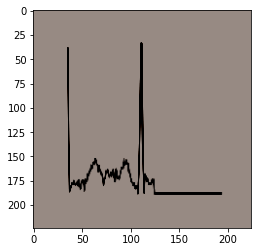

In [10]:
plt.imshow(test_images[0][0][0], cmap='gray')

# Create ResNet50 Model (GPU)

In [20]:
# Create the neural network model
def convolutional_model(base_model, device):
    with tf.device(device):
        model = Sequential()
        model.add(base_model)
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dense(6, activation='softmax'))  # Add a dense layer with 4 units and softmax activation

        # Print a summary of the model architecture
        model.summary()

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

        return model
    
# Load the ResNet50 model without the fully connected layers
base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model to avoid training during fine-tuning
base_model.trainable = False

# Create ResNet50 model using AMD GPU
resnet50_model = convolutional_model(base_model, 'CPU')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                      

# Model Callbacks

In [21]:
# Save best model and create early stop
cb_checkpointer = ModelCheckpoint(filepath='./best_not_segmented.hdf5', save_weights_only=False, monitor='val_acc', save_best_only=True, mode='max', verbose=1)

# Fit Model

In [22]:
# Fit model with train and validation, and add callbacks
step_size_train = train_images.n//train_images.batch_size
step_size_validation = validation_images.n//validation_images.batch_size

resnet50_model.fit(
    train_images,
    validation_data=validation_images,
    epochs=30,
    callbacks=[cb_checkpointer],
    validation_steps=step_size_validation,
    steps_per_epoch=step_size_train
)
resnet50_model.load_weights("./best_not_segmented.hdf5")

Epoch 1/30
96/96 [==============================] - ETA: 0s - loss: 2.3828 - acc: 0.1624
Epoch 00001: val_acc improved from -inf to 0.30208, saving model to .\best_not_segmented.hdf5
96/96 [==============================] - 537s 6s/step - loss: 2.3828 - acc: 0.1624 - val_loss: 1.7181 - val_acc: 0.3021
Epoch 2/30
30/96 [========>.....................] - ETA: 4:57 - loss: 2.1512 - acc: 0.2177

KeyboardInterrupt: 

# Evaluation Model

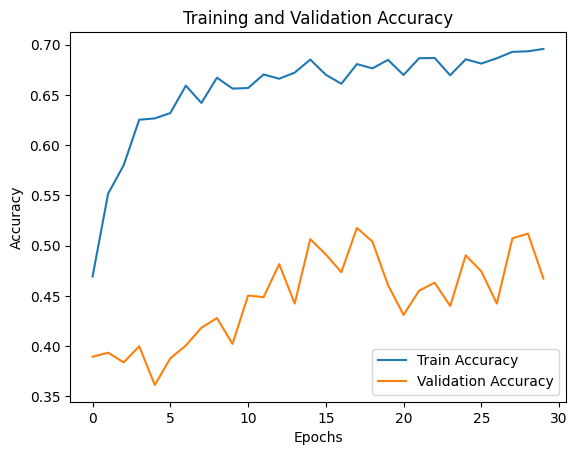

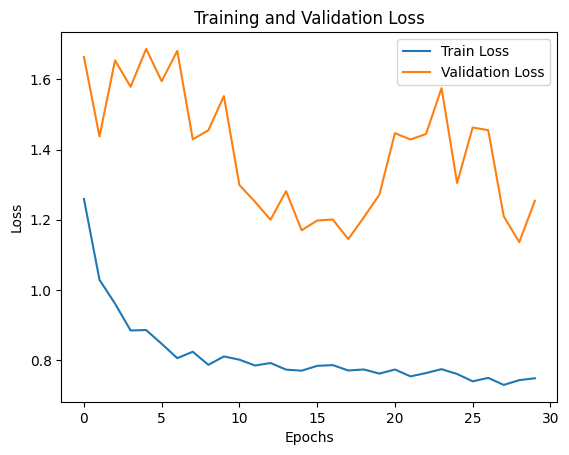

In [15]:
# Obter as métricas de treinamento
train_accuracy = resnet50_model.history.history['acc']
train_loss = resnet50_model.history.history['loss']

# Obter as métricas de validação
val_accuracy = resnet50_model.history.history['val_acc']
val_loss = resnet50_model.history.history['val_loss']

# Criar gráfico da acurácia
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Criar gráfico da perda
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [23]:
# Calcular as métricas nos dados de validatione (mesmo que o gerador de validação)
validation_results = resnet50_model.evaluate_generator(validation_generator, steps=1)

# Extrair as métricas
validation_loss = validation_results[0]
validation_accuracy = validation_results[1]
validation_precision = validation_results[2]
validation_recall = validation_results[3]

# Imprimir as métricas
print(f'Validation Loss: {round(validation_loss, 2)}')
print(f'Validation Accuracy: {round(validation_accuracy * 100, 2)}%')
print(f'Validation Precision: {round(validation_precision * 100, 2)}%')
print(f'Validation Recall: {round(validation_recall* 100, 2)}%')

Validation Loss: 1.05
Validation Accuracy: 59.38%
Validation Precision: 68.18%
Validation Recall: 46.88%


In [31]:
from sklearn.metrics import confusion_matrix

validation_predictions = resnet50_model.predict_generator(validation_generator, steps=1)

y_pred = np.argmax(validation_predictions, axis=1)
y_pred

array([1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 3, 3, 0, 1, 1, 1, 2, 1,
       0, 2, 2, 2, 1, 3, 1, 1, 2, 2], dtype=int64)

# Testar o Modelo para 1 imagem

In [102]:
# Carregar a imagem
image_path = 'images_train_segmented_increased\IV\g_right_mlo (1).png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter o padrão de cores para RGB
image = cv2.resize(image, (224, 224))  # Redimensionar a imagem para o tamanho esperado pelo modelo (224x224)
image = np.expand_dims(image, axis=0)  # Adicionar uma dimensão extra para representar o batch de imagens

# Pré-processar a imagem
image = preprocess_input(image)

# Predicao
predictions = resnet50_model.predict(image)

# Interpretar as previsões
class_names = ['I', 'II', 'III', 'IV']
predicted_class = np.argmax(predictions[0])
predicted_label = class_names[predicted_class]

# Calcular a precisão da previsão
accuracy = predictions[0][predicted_class]

print('Previsão:', predicted_label)
print('Precisão:', accuracy)

Previsão: IV
Precisão: 0.65678275
